In [2]:
!pip install matplotlib
!pip install numpy
!pip install scikit-learn
!pip install seaborn

     |████████████████████████████████| 17.7 MB 1.3 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.3
    Uninstalling numpy-1.26.3:
      Successfully uninstalled numpy-1.26.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
tensorflow 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 1.22.4 which is incompatible.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.22.4 which is incompatible.


In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
import seaborn as sns

In [4]:
os.getcwd()

'/Users/hayleyluo/Desktop/Github/ML-kaggle-housing-price-regression/Notebook'

In [5]:
# read in data into dataframe
# train and test sets are 50/50 split, potentially can use cross-validation
traindata_path="../train.csv"
testdata_path="../test.csv"
df_train = pd.read_csv(traindata_path, sep=",", header=0)
df_test = pd.read_csv(testdata_path, sep=",", header=0)

In [9]:
df_test.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'Pav

array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'OverallQual'}>,
        <AxesSubplot:title={'center':'OverallCond'}>],
       [<AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'YearRemodAdd'}>,
        <AxesSubplot:title={'center':'MasVnrArea'}>,
        <AxesSubplot:title={'center':'BsmtFinSF1'}>,
        <AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>],
       [<AxesSubplot:title={'center':'TotalBsmtSF'}>,
        <AxesSubplot:title={'center':'1stFlrSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>,
        <AxesSubplot:title={'center':'LowQualFinSF'}>,
        <AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'BsmtFullBath'}>],
       [<AxesSubplot:title={'center':'BsmtHalfBath'

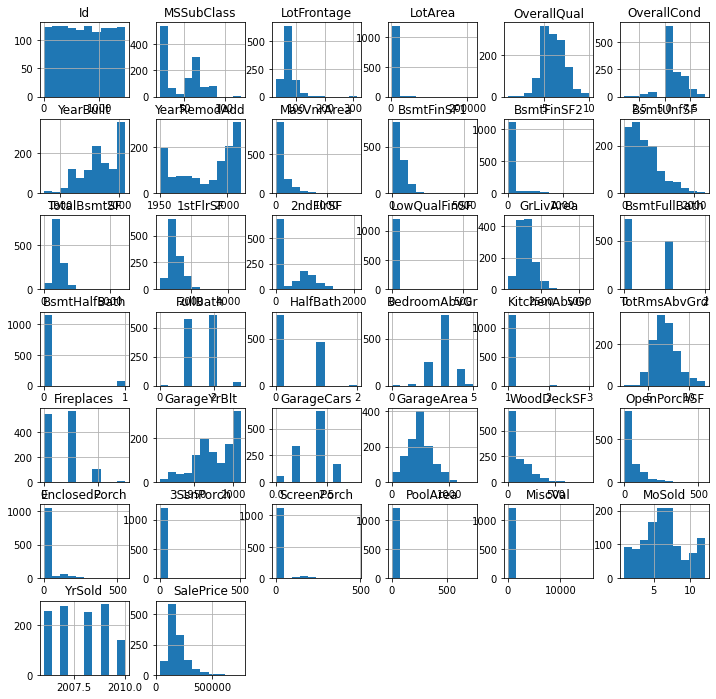

In [10]:
# exam the  data
df_train[df_train.BldgType=="1Fam"].hist(figsize=(12,12))

In [11]:
# function that convert dataframe's col to index
def encode_column_w_index(df):
    df_col_names = list(df.columns.values)
    keys = [i for i in range(len(df.columns.values))]
    index_to_col_dict = dict(zip(keys, df_col_names))
    col_to_index_dict = dict(zip(df_col_names,keys))
    return index_to_col_dict, col_to_index_dict

In [12]:
# make this into a class
def encode_string_columns(df):
    # identify the string cols and the numerical cols
    column_names = list(df.columns.values)
    dtype_map = df.dtypes
    numerical_columns = []
    str_columns = []
    for col in column_names:
        nan_count = df[col].isna().sum()
        col_type = str(dtype_map[col])
        if (col_type=="int64" or col_type=="float64"):
            numerical_columns.append(col)
        if (col_type=="object"):
            str_columns.append(col)
    print("numerical_columns: ", numerical_columns)
    print("str_columns: ", str_columns)

    # select all the string columns
    df_str = df[str_columns].fillna(value="no data")
    df_numerical = df[numerical_columns].fillna(value=0)

    # generate the encoded dictionaries for string columns
    dict_df_index_to_col, dict_df_col_to_index =encode_column_w_index(df_str)

    # encode the string data
    enc = OrdinalEncoder()
    np_str_ecoded=enc.fit_transform(df_str)
    # enc.categories_
    # trace_back_dict = {i: dict(enumerate(v)) for i, v in enumerate(enc.categories_)}
    # trace_back_dict

    df_str_ecoded = pd.DataFrame(np_str_ecoded, columns=dict_df_col_to_index.keys())

    df_encoded = pd.concat([df_numerical, df_str_ecoded], axis=1)
    return df_encoded, enc

In [13]:
def heatmap(df, val_min, val_max, file_name) :
    corr = df.corr()
    # Mask values that is not fall between min and max value
    corr_selected = corr.mask(((corr < val_min) | (corr > val_max)), float("NaN"))
    
    # Get the upper triangular matrix
    # Use `tril` instead of `triu` if the lower triangular matrix is needed
    # Use `np.bool_` instead of `np.bool` if you using NumPy >= 1.20
    corr_selected = corr_selected.where(np.tril(np.ones(corr_selected.shape)).astype(np.bool_))
    
    # Remove rows that contains only NaN
    corr_selected = corr_selected.dropna(axis=0,how="all",)
    
    # Remove columns that contains only NaN
    corr_selected = corr_selected.dropna(axis=1,how="all",)
    
    plt.figure(figsize=(50, 40))
    heatmap = sns.heatmap(corr_selected,vmin=-1, vmax=1);
    heatmap.hlines(range(1, len(corr_selected)), *heatmap.get_xlim())
    heatmap.vlines(range(1, len(corr_selected)), *heatmap.get_xlim())
    plt.savefig(file_name, dpi=500, bbox_inches='tight')
    return corr

In [14]:
df_train_encoded, encoder = encode_string_columns(df_train)
dict_dftrain_index_to_column, dict_dftrain_column_to_index =encode_column_w_index(df_train_encoded)

scaler = StandardScaler()
train_data = scaler.fit_transform(df_train_encoded)

numerical_columns:  ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
str_columns:  ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', '

In [15]:
df_train_normalized = pd.DataFrame(train_data, columns=dict_dftrain_column_to_index.keys()) 
#df_train_normalized.hist(figsize=(40,40))

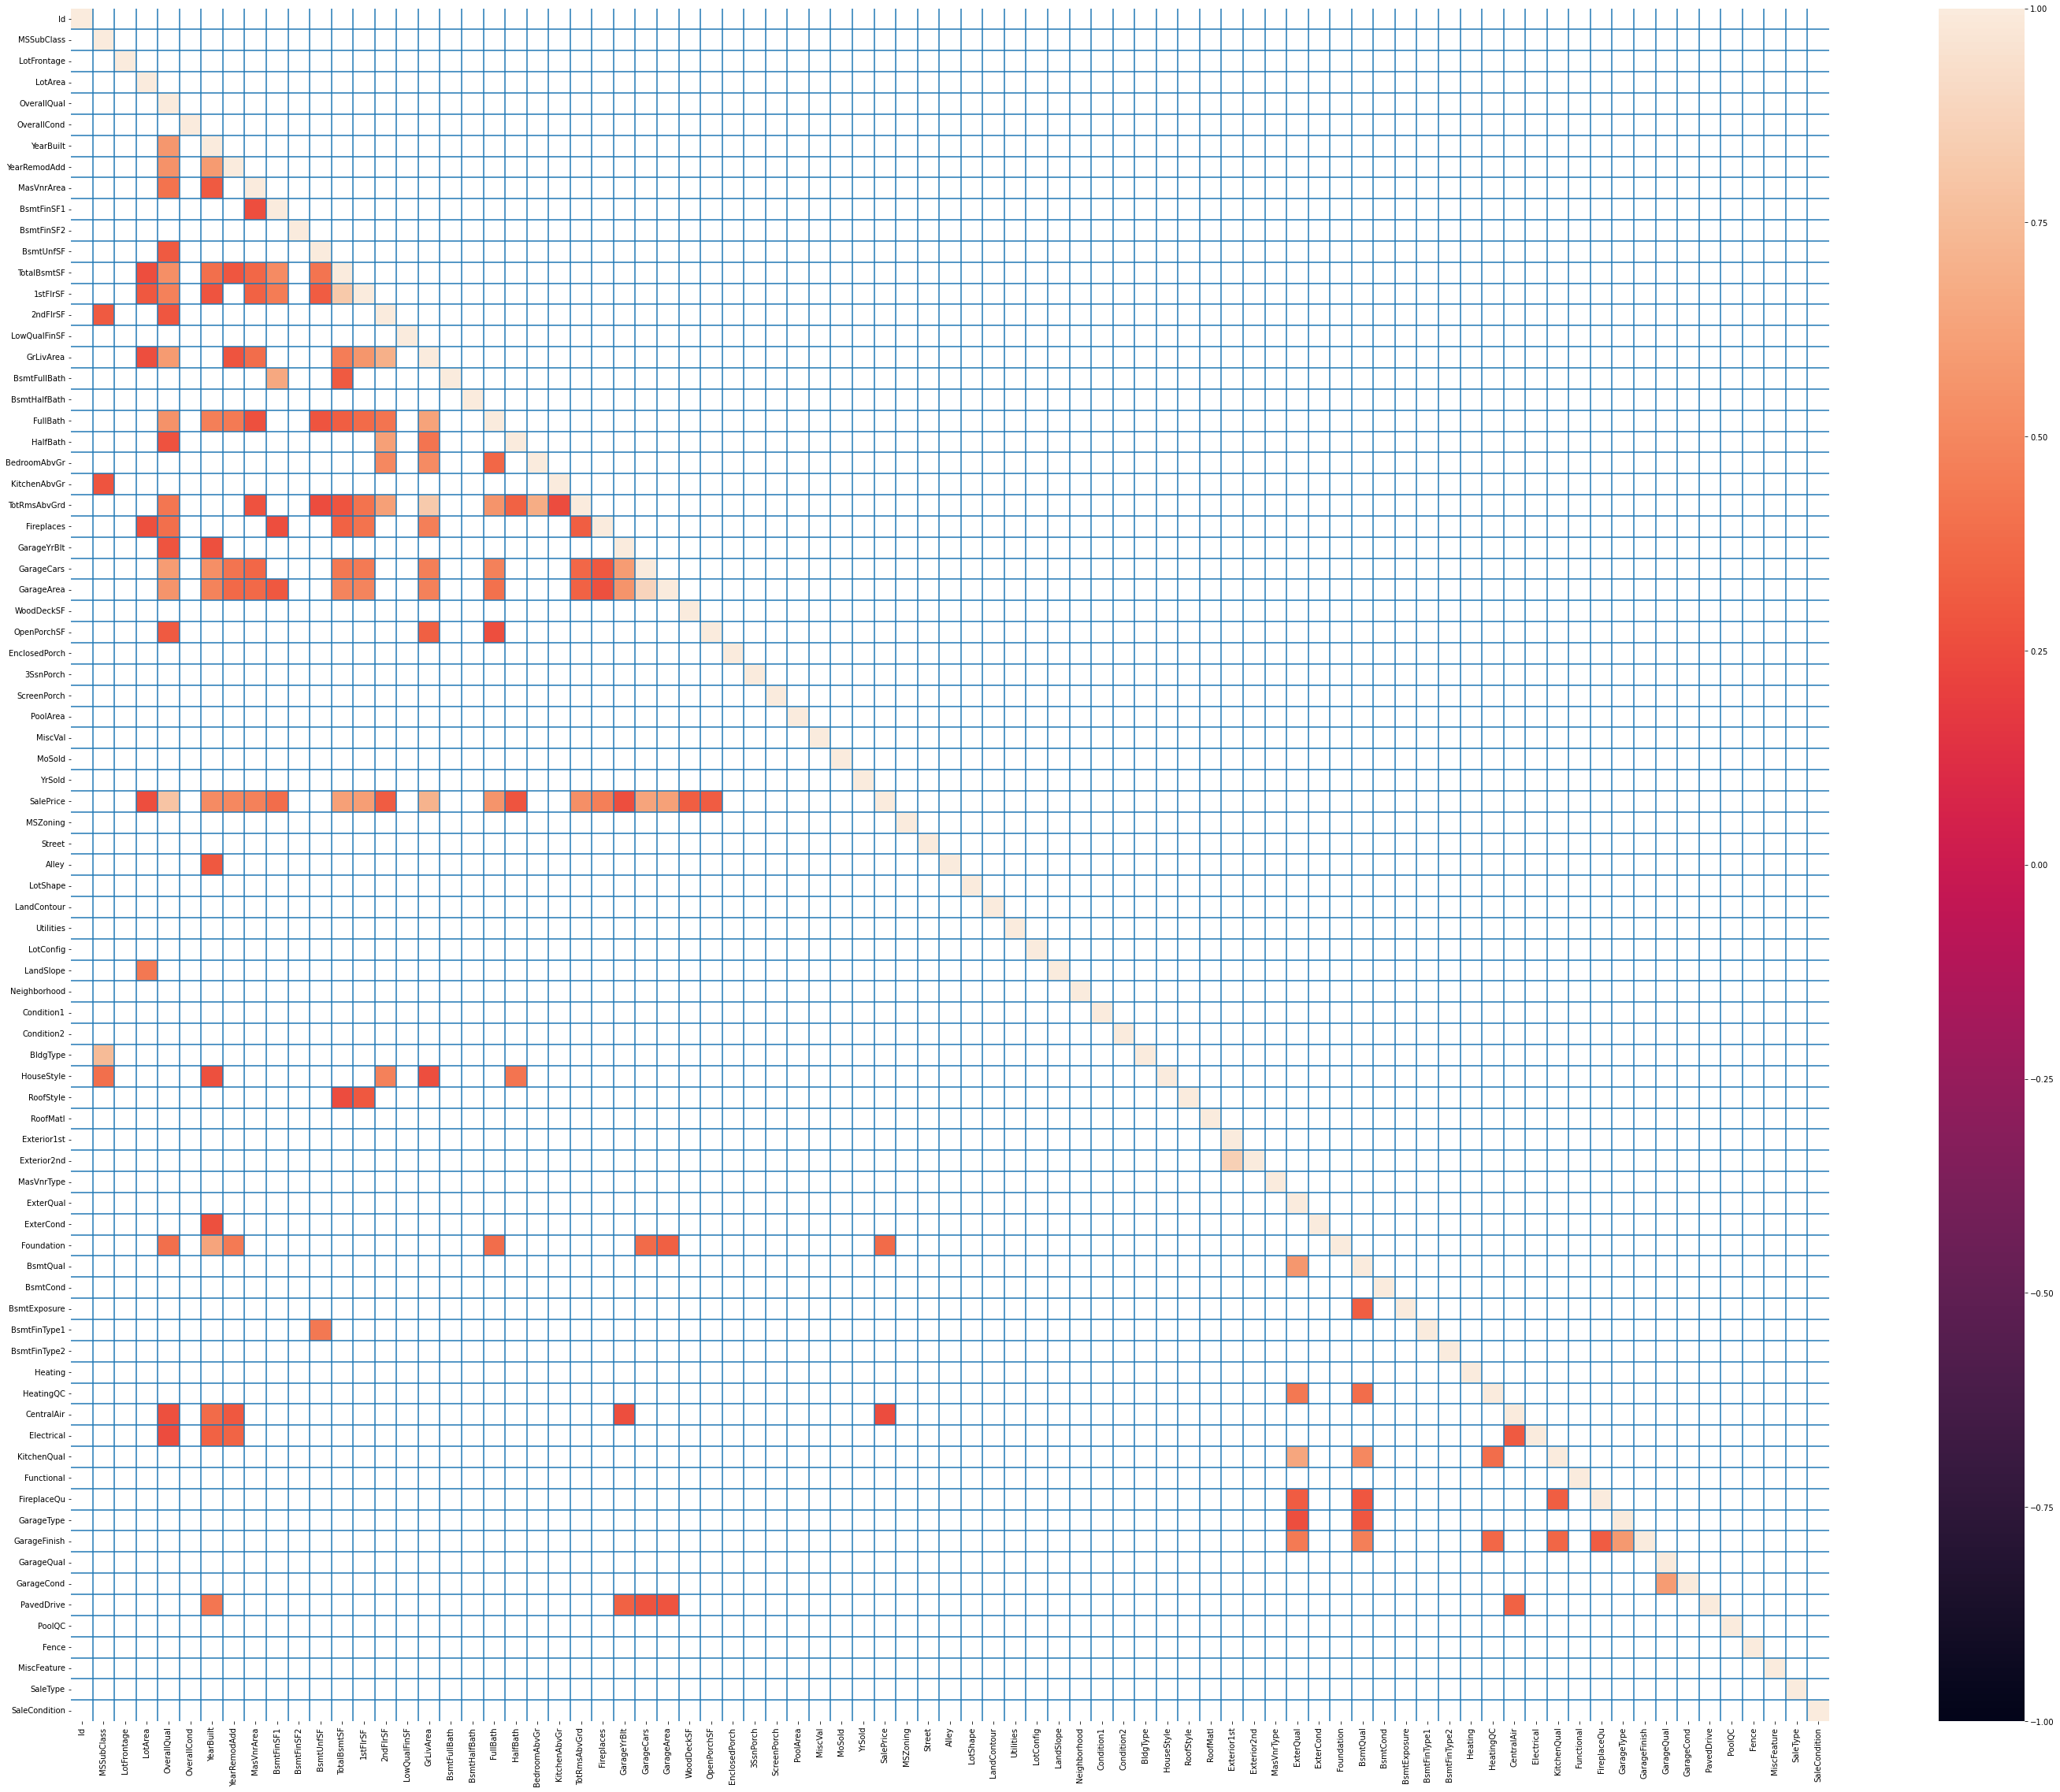

In [16]:
corr = heatmap(df_train_normalized, 0.25, 1, "train_X_heatmap")

In [18]:
# select features for the model
features = corr.loc[(abs(corr['SalePrice'])>=0.3) & (abs(corr['SalePrice'])!=1.0), :].index

In [19]:
df_train_x = df_train[features]
df_train_x_encoded, encoder = encode_string_columns(df_train_x)
df_train_y = pd.DataFrame(df_train['SalePrice'], columns=['SalePrice'])

numerical_columns:  ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']
str_columns:  ['ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish']


In [20]:
scaler = StandardScaler()
train_X = scaler.fit_transform(df_train_x_encoded)
train_X[np.isnan(train_X)] = 0
train_Y = scaler.fit_transform(df_train_y)

In [21]:
print("train_X: ", train_X.shape, "train_Y", train_Y.shape)

train_X:  (1460, 25) train_Y (1460, 1)


In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
degree = 6
poly = PolynomialFeatures(degree)
poly_features_train = poly.fit_transform(train_X)
X_train, X_test, y_train, y_test = train_test_split(poly_features_train, train_Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train, y_train)
poly_reg_y_val = poly_reg_model.predict(X_val)
poly_reg_y_train = poly_reg_model.predict(X_train)


In [23]:
poly_reg_rmse_val = np.sqrt(mean_squared_error(y_val, poly_reg_y_val))

In [19]:
poly_reg_rmse_train = np.sqrt(mean_squared_error(y_train, poly_reg_y_train))

In [20]:
poly_reg_y_test = poly_reg_model.predict(X_test)
poly_reg_rmse_test = np.sqrt(mean_squared_error(y_test, poly_reg_y_test))

In [21]:
poly_reg_rmse_val

36.87597907267269

In [22]:
poly_reg_rmse_train

0.00225626484153549

In [23]:
poly_reg_rmse_test

66.82735025348586

In [24]:
print(np.var(y_val))

0.8525096735189037
